In [1]:
import pandas as pd
import numpy as np
import os

os.chdir('/home/kruu/git_folder/eye_tracking/')
from utils.data_processing import EyeTrackingProcessor

import torch
from models.lstm_autoencoder import train_autoencoder, LSTMAutoencoder, get_latent_representation

import matplotlib.pyplot as plt

****
# Import Datasets
****

In [2]:
data_path = "/store/kruu/eye_tracking"
files_list = os.listdir(data_path)
files_list = [os.path.join(data_path, file) for file in files_list]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']
interpolate_col = ['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']

processor = EyeTrackingProcessor()
all_data = processor.load_data(files_list)
dataset = processor.get_features(all_data, tasks, features)

#Fixed Time step resampling
dataset_resampled = processor.fixed_time_steps_resample(dataset, interpolate_col, timestep = 0.1)
dataset_resampled.fillna(0, inplace=True)


/home/kruu/git_folder/eye_tracking/utils/data_processing.py:19: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/home/kruu/git_folder/eye_tracking/utils/data_processing.py:19: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


****
# AutoEncoder
****

In [ ]:
features = ['Relative timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']
model = train_autoencoder(dataset_resampled,
                          features,
                          batch_size=32,
                          hidden_dim=64,
                          latent_dim=32,
                          num_layers=2,
                          learning_rate=0.001,
                          num_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | encoder_lstm | LSTM    | 135 K  | train
1 | fc           | Linear  | 2.1 K  | train
2 | decoder_lstm | LSTM    | 149 K  | train
3 | output_layer | Linear  | 645    | train
4 | criterion    | MSELoss | 0      | train
--------------------------------

Epoch 99: 100%|██████████| 14/14 [00:52<00:00,  0.27it/s, v_num=2, train_loss_step=0.0898, train_loss_epoch=0.0753]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 14/14 [00:52<00:00,  0.27it/s, v_num=2, train_loss_step=0.0898, train_loss_epoch=0.0753]


In [ ]:
# model.eval()
# with torch.no_grad():
#     for batch in dataloader:
#         x, seq_lengths = batch
#         reconstructed = model(x, seq_lengths)
#         break  # Take only one batch for visualization

# # Convert to numpy for analysis
# reconstructed_np = reconstructed.numpy()
# original_np = x.numpy()

# # Print an example
# print("Original Sequence:\n", original_np[0])
# print("\nReconstructed Sequence:\n", reconstructed_np[0])

****
# Latent Space
****

In [3]:
ckpt_path = "/home/kruu/git_folder/eye_tracking/lightning_logs/version_2/checkpoints/epoch=99-step=1400.ckpt"
    
model_load = LSTMAutoencoder(input_dim=5, hidden_dim=64, latent_dim=32, num_layers=2, learning_rate=0.001)
model_load.load_state_dict(torch.load(ckpt_path)["state_dict"])
model_load.eval()

LSTMAutoencoder(
  (encoder_lstm): LSTM(5, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (decoder_lstm): LSTM(32, 64, num_layers=2, batch_first=True, bidirectional=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
  (criterion): MSELoss()
)

In [6]:
features = ['Relative timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']
latent_vector, tasks = get_latent_representation(model_load, dataset_resampled, features)

[0.4253067  0.22226304 0.14806671]


/tmp/ipykernel_2774453/3706516939.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


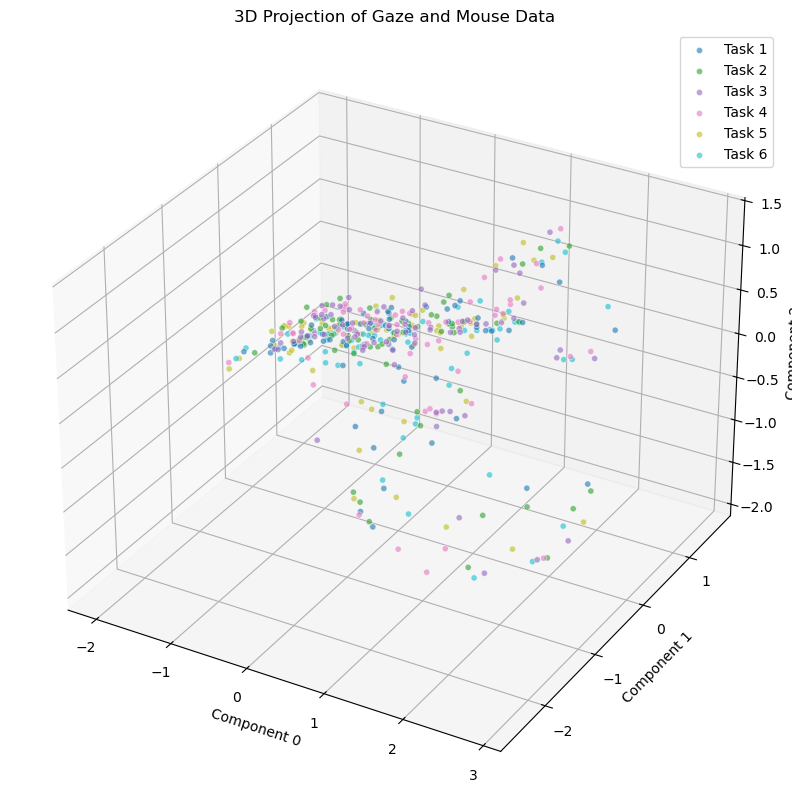

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
embeddings = pca.fit_transform(latent_vector)
print(pca.explained_variance_ratio_)

# Create a color map for labels
unique_labels = np.unique(tasks)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(tasks)
for i, label in enumerate(unique_labels):
    indices = tasks == label
    ax.scatter(embeddings[indices, 0], embeddings[indices, 1], embeddings[indices, 2],
               color=colors(i), label=f'Task {label}', alpha=0.6, edgecolors='w', linewidth=0.5)

ax.set_title('3D Projection of Gaze and Mouse Data')
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.legend()
plt.show()